# Use `jaxspec` with external samplers

In this tutorial, we demonstrate how to use the vectorized and compilable log-likelihood and posterior log-probability
as implemented in `jaxspec` in external samplers. We will use the [`zeus`](https://zeus-mcmc.readthedocs.io/en/latest/) sampler. Let's first import all the necessary packages and setup the basic configuration for `JAX`.

In [1]:
%%capture 
# Hide the output of this cell
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")

import arviz as az 
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import zeus
import jax
import numpy as np
from jaxspec.data.util import load_example_obsconf
from jaxspec.fit import BayesianModel, MCMCFitter
from jaxspec.model.additive import Powerlaw, Blackbodyrad
from jaxspec.model.multiplicative import Tbabs

Now, instead of the casual [`MCMCFitter`](/references/fitting/#jaxspec.fit.MCMCFitter), we build a [`BayesianModel`](/references/fitting/#jaxspec.fit.BayesianModel), which is the parent class of any fitter implemented in `jaxspec`.

In [2]:
spectral_model = Tbabs()*(Powerlaw() + Blackbodyrad())

prior = {
    "powerlaw_1_alpha": dist.Uniform(0, 5),
    "powerlaw_1_norm": dist.LogUniform(1e-5, 1e-2),
    "blackbodyrad_1_kT": dist.Uniform(0, 5),
    "blackbodyrad_1_norm": dist.LogUniform(1e-2, 1e2),
    "tbabs_1_N_H": dist.Uniform(0, 1)
}

ulx_observations = load_example_obsconf("NGC7793_ULX4_ALL")
bayesian_model = BayesianModel(spectral_model, prior, ulx_observations)

 The [`BayesianModel`](/references/fitting/#jaxspec.fit.BayesianModel) class exposes methods to compute the log-likelihood and posterior log-probability associated with any set of parameters. These functions are pure `JAX` function, so they can be freely nested with the `jit` or `vmap` operators. In the following cell, we also use the [`array_to_dict`](/references/fitting/#jaxspec.fit.BayesianModel.array_to_dict) method to build a compiled and vectorized posterior log-probability function that accepts `numpy` arrays as input. We can use it with the `emcee` sampler and launch a MCMC run. To check the parameter order in the function we build, use the following line:

In [3]:
bayesian_model.parameter_names

['blackbodyrad_1_kT',
 'blackbodyrad_1_norm',
 'powerlaw_1_alpha',
 'powerlaw_1_norm',
 'tbabs_1_N_H']

In [4]:
ndim, nwalkers = len(bayesian_model.parameter_names), 20
p0 = np.array([[0.7, 0.2, 2, 3e-4, 0.1]])*np.random.normal(loc=1, scale=0.1, size=(nwalkers, ndim))

@jax.jit
@jax.vmap
def zeus_log_prob(parameters: np.ndarray) -> jax.typing.ArrayLike:
    return bayesian_model.log_posterior_prob(bayesian_model.array_to_dict(parameters))

sampler = zeus.EnsembleSampler(
    nwalkers, ndim, zeus_log_prob, vectorize=True
)

sampler.run_mcmc(p0, 10_000, progress=True);

Initialising ensemble of 20 walkers...
Sampling progress : 100%|██████████| 10000/10000 [09:25<00:00, 17.69it/s]


Note how we initialized the chains close to the expected values. Now let's check the convergence of the chain using `arviz`.

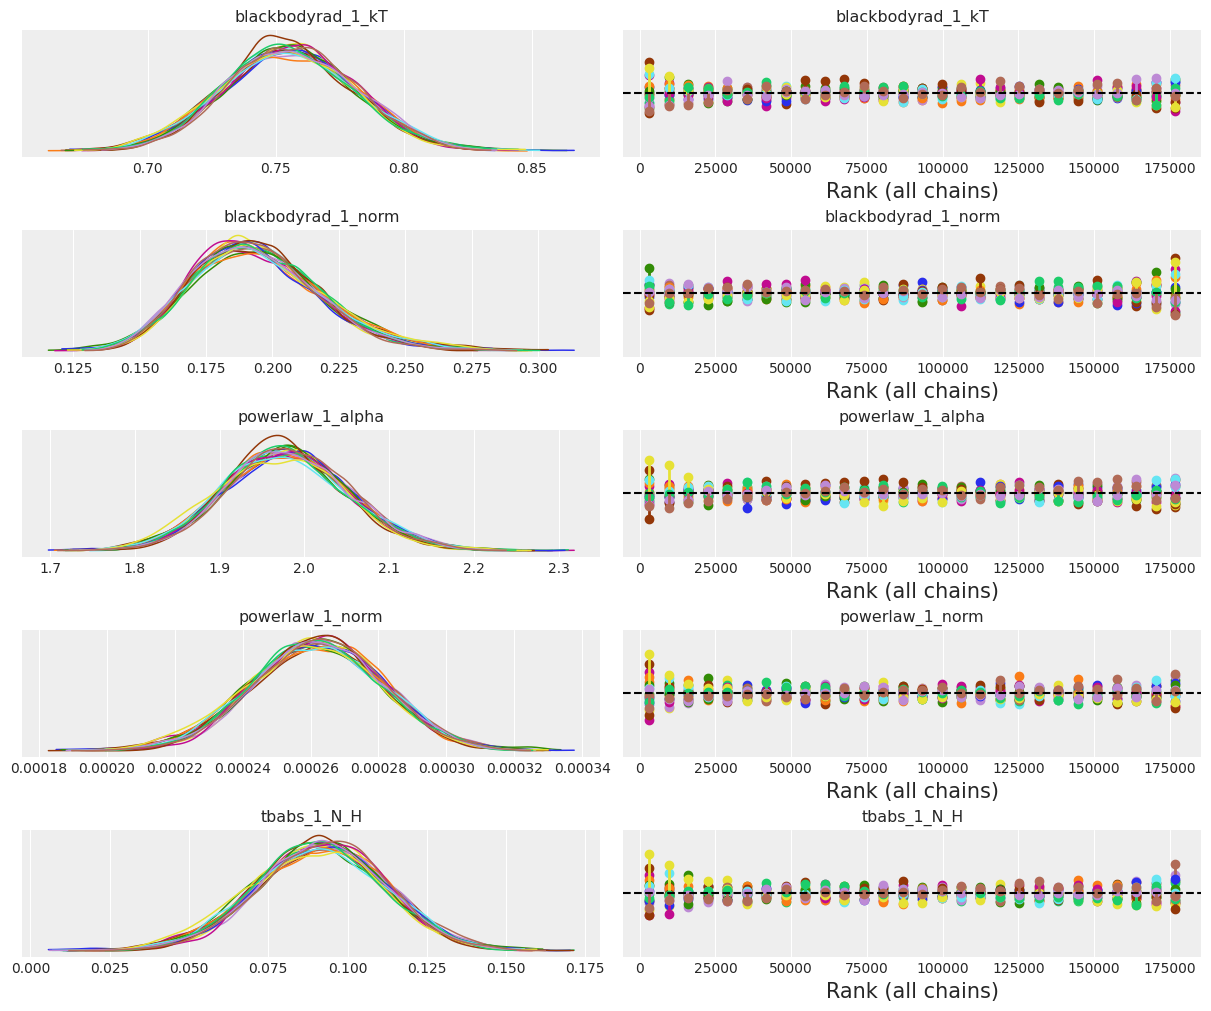

In [5]:
inference_data_zeus= az.from_emcee(sampler, var_names=bayesian_model.parameter_names).sel(draw=slice(1_000, None))

with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(inference_data_zeus, compact=False, kind="rank_vlines");

Everything seems fine, but never forget that assessing convergence should not be as trivial as looking at the trace plot, check the [good practices tutorial](/examples/work_with_arviz/) on this topic. Let's check if the results are agreeing with what we would obtain using the No U-Turn Sampler. 

In [6]:
result = MCMCFitter(spectral_model, prior, ulx_observations).fit()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

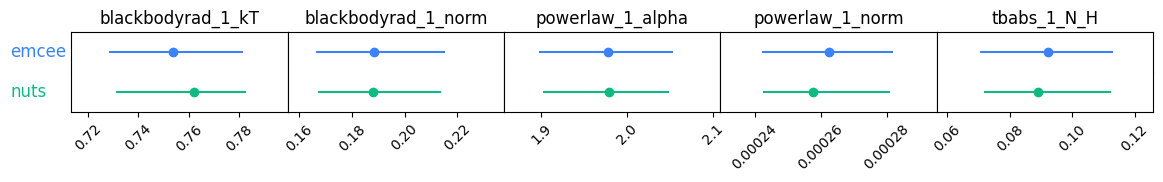

In [7]:
from chainconsumer import ChainConsumer, Chain, PlotConfig

chain_emcee = Chain.from_emcee(sampler, bayesian_model.parameter_names, "emcee")
chain_nuts = result.to_chain("nuts")

cc = ChainConsumer()
cc.set_plot_config(PlotConfig())
cc.add_chain(chain_emcee)
cc.add_chain(chain_nuts)

cc.plotter.plot_summary(errorbar=True, figsize=0.8)

for ax in plt.gcf().get_axes():
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()

We got equivalent results using `zeus` with few steps and a proper initialisation. The posterior log-probability function we built can be fed with any kind of `numpy` or `JAX` arrays, and should be easy to use with your favorite framework.